# 2D CNN training
This notebook works as a proof of concept version for the actual script

## from scratch

## pretrained

### Vision Transformer

Import the standard libraries, watchout though: vit_keras uses tensorflow_addons, which has stopped any development

In [354]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
import random
import os
import glob
from functools import partial
from time import strftime

from vit_keras import vit

helper functions below

In [355]:
path_to_tfrs = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_slices_tfrecords/all_pats_single_rgb"
path_to_logs = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_slices_tfrecords/test_logs"

training_codename = "2D_pretrained_0000"

num_classes = 3
sequence_to_train_on = "t1c"

time = strftime("run_%Y_%m_%d_%H_%M_%S")
class_directory = f"{training_codename}_{num_classes}_classes_{time}"

path_to_callbacks = Path(path_to_logs) / Path(class_directory)
os.makedirs(path_to_callbacks, exist_ok=True)



image_size = 224

## train / val / test split
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

early_stopping_patience = 150
shuffle_buffer_size = 20
repeat_count = 1

image_size = 224
batch_size = 16
EPOCHS = 30

len_train = 0
len_val = 0
len_test = 0

In [356]:
def get_patient_paths():
    patients = [f for f in os.listdir(path_to_tfrs) if os.path.isdir(os.path.join(path_to_tfrs, f))]

    patient_paths = [str(path_to_tfrs) + "/" + patient for patient in patients]

    print(f"total patients: {len(patient_paths)}")

    for path in patient_paths:
        patient_not_empty = False
        patient_files = os.listdir(path)
        for file in patient_files:
            if file.endswith(".tfrecord"):
                patient_not_empty = True
        
        if patient_not_empty == False:
            patient_paths.remove(path)

    return patient_paths

def split_patients(patient_paths, fraction_to_use = 1):

    random.shuffle(patient_paths)

    patient_paths = patient_paths[:int(len(patient_paths) * fraction_to_use)]

    if fraction_to_use != 1:
        print(f"actual tfrs length: {len(patient_paths)}")

    train_size = int(len(patient_paths) * train_ratio)
    val_size = int(len(patient_paths) * val_ratio)

    train_patients_paths = patient_paths[:train_size]
    val_patients_paths = patient_paths[train_size:train_size + val_size]
    test_patients_paths = patient_paths[train_size + val_size:]

    print(f"train: {len(train_patients_paths)} | val: {len(val_patients_paths)} | test: {len(test_patients_paths)}")

    # save train / val / test patients to txt file
    # hf.save_paths_to_txt(train_patients_paths, "train", path_to_callbacks)
    # hf.save_paths_to_txt(val_patients_paths, "val", path_to_callbacks)
    # hf.save_paths_to_txt(test_patients_paths, "test", path_to_callbacks)

    sum = len(train_patients_paths) + len(val_patients_paths) + len(test_patients_paths)
    if sum != len(patient_paths):
        print("WARNING: error occured in train / val / test split!")

    return train_patients_paths, val_patients_paths, test_patients_paths

def get_tfr_paths_for_patients(patient_paths):

    tfr_paths = []

    for patient in patient_paths:
        tfr_paths.extend(glob.glob(patient + "/*.tfrecord"))
    
    for path in tfr_paths:
        verify_tfrecord(path)

    #print(f"total tfrs: {len(tfr_paths)}")

    return tfr_paths

def read_data(train_paths, val_paths, test_paths = None):

    train_data = tf.data.Dataset.from_tensor_slices(train_paths)
    val_data = tf.data.Dataset.from_tensor_slices(val_paths)

    train_data = train_data.interleave(
        lambda x: tf.data.TFRecordDataset([x], compression_type="GZIP"),
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=False
    )
    val_data = val_data.interleave(
        lambda x: tf.data.TFRecordDataset([x], compression_type="GZIP"),
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=False
    )

    train_data = train_data.map(partial(parse_record, image_only = True, labeled = True, num_classes = num_classes), num_parallel_calls=tf.data.AUTOTUNE)
    val_data = val_data.map(partial(parse_record, image_only = True, labeled = True, num_classes = num_classes), num_parallel_calls=tf.data.AUTOTUNE)

    train_data = train_data.shuffle(buffer_size=shuffle_buffer_size)
    val_data = val_data.shuffle(buffer_size=shuffle_buffer_size)

    train_data = train_data.repeat(count = repeat_count)
    val_data = val_data.repeat(count = repeat_count)

    train_data = train_data.batch(batch_size)
    val_data = val_data.batch(batch_size)

    train_data = train_data.prefetch(buffer_size=1)
    val_data = val_data.prefetch(buffer_size=1)

    if test_paths is not None:
        test_data = tf.data.Dataset.from_tensor_slices(test_paths)
        test_data = test_data.interleave(
            lambda x: tf.data.TFRecordDataset([x], compression_type="GZIP"),
            num_parallel_calls=tf.data.AUTOTUNE,
            deterministic=False
        )
        test_data = test_data.map(partial(parse_record, image_only = True, labeled = True, num_classes = num_classes), num_parallel_calls=tf.data.AUTOTUNE)
        test_data = test_data.batch(batch_size)
        test_data = test_data.prefetch(buffer_size=1)

        return train_data, val_data, test_data

    return train_data, val_data

def parse_record(record, image_only = False, labeled = False, num_classes = 2, sequence = "t1c"):

    feature_description = {
        "image": tf.io.FixedLenFeature([240, 240, 3, 4], tf.float32),
        "sex": tf.io.FixedLenFeature([], tf.int64, default_value=[0]),
        "age": tf.io.FixedLenFeature([], tf.int64, default_value=0),
        "primary": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    }

    example = tf.io.parse_single_example(record, feature_description)
    image = example["image"]
    image = tf.reshape(image, [240, 240, 3, 4])
    #image = data_augmentation(image)

    # primary should have a value between 0 and 5
    # depending on num classes return different values
    # if num_classes = 2, return 1 if primary is 1, else 0
    # if num_classes = 3, return primaries 1 and 2, else 0
    # if num_classes = 4, return primaries 1, 2 and 3, else 0
    # if num_classes = 5, return primaries 1, 2, 3 and 4, else 0
    # if num_classes = 6, return primaries 1, 2, 3, 4 and 5, else 0

    primary_to_return = tf.constant(0, dtype=tf.int64)

    if num_classes == 2:
        if example["primary"] == tf.constant(1, dtype=tf.int64):
            primary_to_return = example["primary"]
        else:
            primary_to_return = tf.constant(0, dtype=tf.int64)
    elif num_classes == 3:
        if example["primary"] == tf.constant(1, dtype=tf.int64) or example["primary"] == tf.constant(2, dtype=tf.int64):
            primary_to_return = example["primary"]
        else:
            primary_to_return = tf.constant(0, dtype=tf.int64)
    elif num_classes == 4:
        if example["primary"] == tf.constant(1, dtype=tf.int64) or example["primary"] == tf.constant(2, dtype=tf.int64) or example["primary"] == tf.constant(3, dtype=tf.int64):
            primary_to_return = example["primary"]
        else:
            primary_to_return = tf.constant(0, dtype=tf.int64)
    elif num_classes == 5:
        if example["primary"] == tf.constant(1, dtype=tf.int64) or example["primary"] == tf.constant(2, dtype=tf.int64) or example["primary"] == tf.constant(3, dtype=tf.int64) or example["primary"] == tf.constant(4, dtype=tf.int64):
            primary_to_return = example["primary"]
        else:
            primary_to_return = tf.constant(0, dtype=tf.int64)
    elif num_classes == 6:
        if example["primary"] == tf.constant(1, dtype=tf.int64) or example["primary"] == tf.constant(2, dtype=tf.int64) or example["primary"] == tf.constant(3, dtype=tf.int64) or example["primary"] == tf.constant(4, dtype=tf.int64) or example["primary"] == tf.constant(5, dtype=tf.int64):
            primary_to_return = example["primary"]
        else:
            primary_to_return = tf.constant(0, dtype=tf.int64)
    else:
            print("ERROR")
            print("num classes not supported")
            print("Check parse_record function")
            print("____________________________")

    
    if sequence == "t1":
        image = image[:, :, :, 0]
    elif sequence == "t1c":
        image = image[:, :, :, 1]
    elif sequence == "t2":
        image = image[:, :, :, 2]
    elif sequence == "flair":
        image = image[:, :, :, 3]

    if image_only:
        return image, primary_to_return
    elif labeled:
        return (image, example["sex"], example["age"]), primary_to_return #example["primary"]
    else:
        return image
    
def verify_tfrecord(file_path):
    try:
        for _ in tf.data.TFRecordDataset(file_path, compression_type="GZIP"):
            pass
    except tf.errors.DataLossError:
        print(f"Corrupted TFRecord file: {file_path}")

def get_callbacks(fold_num = 0,
                  use_checkpoint = True,
                  use_early_stopping = True,
                  early_stopping_patience = early_stopping_patience,
                  use_tensorboard = True,
                  use_csv_logger = True,
                  use_lrscheduler = False):

    callbacks = []

    path_to_fold_callbacks = path_to_callbacks / f"fold_{fold_num}"

    def get_run_logdir(root_logdir = path_to_fold_callbacks / "tensorboard"):
        return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")

    run_logdir = get_run_logdir()

    # model checkpoint
    if use_checkpoint:
        checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
            filepath = path_to_fold_callbacks / "saved_weights.weights.h5",
            monitor = "val_accuracy",
            mode = "max",
            save_best_only = True,
            save_weights_only = True,
        )
        callbacks.append(checkpoint_cb)

    # early stopping
    if use_early_stopping:
        early_stopping_cb = tf.keras.callbacks.EarlyStopping(
            patience = early_stopping_patience,
            restore_best_weights = True,
            verbose = 1
        )
        callbacks.append(early_stopping_cb)

    # tensorboard, doesn't really work yet
    if use_tensorboard:
        tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir = run_logdir,
                                                    histogram_freq = 1)
        callbacks.append(tensorboard_cb)
    
    # csv logger
    if use_csv_logger:
        csv_logger_cb = tf.keras.callbacks.CSVLogger(path_to_fold_callbacks / "training.csv", separator = ",", append = True)
        callbacks.append(csv_logger_cb)
    
    if use_lrscheduler:
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch * 0.0175))
        callbacks.append(lr_schedule)

    print("get_callbacks successful")

    return callbacks

Data augmentation

In [357]:
class NormalizeToRange(tf.keras.layers.Layer):
    def __init__(self, zero_to_one=True):
        super(NormalizeToRange, self).__init__()
        self.zero_to_one = zero_to_one

    def call(self, inputs):
        min_val = tf.reduce_min(inputs)
        max_val = tf.reduce_max(inputs)
        if self.zero_to_one:
            # Normalize to [0, 1]
            normalized = (inputs - min_val) / (max_val - min_val)
        else:
            # Normalize to [-1, 1]
            normalized = 2 * (inputs - min_val) / (max_val - min_val) - 1
        return normalized
    
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode = "horizontal"),
    #tf.keras.layers.Rescaling(1/255),
    tf.keras.layers.RandomContrast(0.5), # consider removing the random contrast layer as that causes pixel values to go beyond 1
    tf.keras.layers.RandomBrightness(factor = (-0.2, 0.4)), #, value_range=(0, 1)
    tf.keras.layers.RandomRotation(factor = (-0.1, 0.1), fill_mode = "nearest"),
    NormalizeToRange(zero_to_one=True),
    tf.keras.layers.RandomTranslation(
        height_factor = 0.05,
        width_factor = 0.05,
        fill_mode = "nearest",
        interpolation = "bilinear"
    ),
    tf.keras.layers.Resizing(image_size, image_size)
])

In [358]:
patients = get_patient_paths()

train_patients, val_patients, test_patients = split_patients(patients, fraction_to_use = 1)

train_paths = get_tfr_paths_for_patients(train_patients)
val_paths = get_tfr_paths_for_patients(val_patients)
test_paths = get_tfr_paths_for_patients(test_patients)
train_data, val_data, test_data = read_data(train_paths, val_paths, test_paths)

len_train = len(train_paths)
len_val = len(val_paths)
len_test = len(test_paths)
print(f"train: {len_train} | val: {len_val} | test: {len_test}")

callbacks = get_callbacks(0)

total patients: 276
train: 216 | val: 27 | test: 28
train: 926 | val: 80 | test: 72
get_callbacks successful


2
(16, 240, 240, 3)
(240, 240, 3)
Min: 0.0
Max: 255.0
Mean: 0.9764930605888367

Min: 0.0
Max: 1.0
Mean: 0.004145030397921801
(224, 224, 3)

(16,)


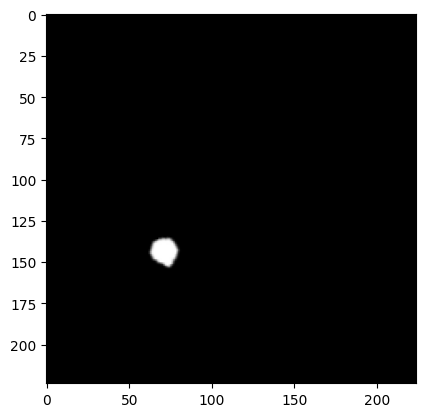

In [349]:
test_image = train_data.take(1)

for image, primary in test_image:
    print(primary.numpy()[0])
    print(image.shape)
    print(image[0].shape)
    image = image[0]
    print(f"Min: {tf.reduce_min(image)}")
    print(f"Max: {tf.reduce_max(image)}")
    print(f"Mean: {tf.reduce_mean(image)}")

    image = data_augmentation(image)
    print()
    print(f"Min: {tf.reduce_min(image)}")
    print(f"Max: {tf.reduce_max(image)}")
    print(f"Mean: {tf.reduce_mean(image)}")
    print(image.shape)

    print()
    print(primary.numpy().shape)

    plt.imshow(image, cmap = "gray")
    

In [350]:
vit_model = vit.vit_b16(
        image_size = image_size,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        #classes = 3
        )

#vit_model.build(input_shape=(image_size, image_size, 3))

/Users/LennartPhilipp/Desktop/Uni/Prowiss/Code/Brain_Mets_Classification/brain_mets_env/lib/python3.11/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [351]:
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [352]:
#input_shape = (224, 224, 3)
#inputs = tf.keras.Input(shape = input_shape)

model_vit = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape = (240, 240, 3)),
        data_augmentation,
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation = tf.keras.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation = tf.keras.activations.gelu),
        tf.keras.layers.Dense(32, activation = tf.keras.activations.gelu),
        tf.keras.layers.Dense(3, activation = 'softmax')
    ],
    name = 'vision_transformer')

model_vit.build()

model_vit.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_27 (Sequential)  (224, 224, 3)             0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten_13 (Flatten)        (None, 768)               0         
                                                                 
 batch_normalization_26 (Ba  (None, 768)               3072      
 tchNormalization)                                               
                                                                 
 dense_52 (Dense)            (None, 128)               98432     
                                                                 
 batch_normalization_27 (Ba  (None, 128)               512       
 tchNormalization)                              

In [353]:
learning_rate = 1e-4

optimizer = tf.optimizers.legacy.Adam(learning_rate = learning_rate)

model_vit.compile(optimizer = optimizer, 
              loss = "sparse_categorical_crossentropy", 
              metrics = ['accuracy'])


early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience = 15, restore_best_weights = True, verbose = 1)

model_vit.fit(x = train_data,
          validation_data = val_data,
          epochs = EPOCHS,
          callbacks = early_stopping_callbacks)

Epoch 1/30


49/49 [==============================] - 186s 4s/step - loss: 1.1954 - accuracy: 0.3222 - val_loss: 1.5543 - val_accuracy: 0.2365
Epoch 2/30
49/49 [==============================] - 176s 4s/step - loss: 1.0872 - accuracy: 0.4433 - val_loss: 2.0845 - val_accuracy: 0.2500
Epoch 3/30
49/49 [==============================] - 180s 4s/step - loss: 1.0691 - accuracy: 0.4845 - val_loss: 1.8574 - val_accuracy: 0.1757
Epoch 4/30
49/49 [==============================] - 180s 4s/step - loss: 1.0676 - accuracy: 0.4601 - val_loss: 1.7427 - val_accuracy: 0.2838
Epoch 5/30
34/49 [===================>..........] - ETA: 51s - loss: 1.0236 - accuracy: 0.5129

KeyboardInterrupt: 

### ResNet50V2

In [359]:
resnet = tf.keras.applications.ResNet50V2(
    include_top=False,
    input_shape=(224,224,3),
    pooling='avg',
    weights='imagenet'
)

94668760/94668760 [==============================] - 6s 0us/step


In [360]:
model_resnet = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (240, 240, 3)),
    data_augmentation,
    resnet,
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation = tf.keras.activations.gelu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation = tf.keras.activations.gelu),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(32, activation = tf.keras.activations.gelu),
    tf.keras.layers.Dense(3, activation = 'softmax')
], name = "resnet")

model_resnet.build()

model_resnet.summary()

Model: "resnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_28 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 flatten_14 (Flatten)        (None, 2048)              0         
                                                                 
 batch_normalization_28 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dense_56 (Dense)            (None, 128)               262272    
                                                                 
 batch_normalization_29 (Ba  (None, 128)               512       
 tchNormalization)                                          

In [361]:
learning_rate = 1e-4

optimizer = tf.optimizers.legacy.Adam(learning_rate = learning_rate)

model_resnet.compile(optimizer = optimizer, 
              loss = "sparse_categorical_crossentropy", 
              metrics = ['accuracy'])


early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience = 15, restore_best_weights = True, verbose = 1)

model_resnet.fit(x = train_data,
          validation_data = val_data,
          epochs = EPOCHS,
          callbacks = early_stopping_callbacks)

Epoch 1/30
58/58 [==============================] - 61s 997ms/step - loss: 1.4287 - accuracy: 0.3326 - val_loss: 1.1051 - val_accuracy: 0.3125
Epoch 2/30
58/58 [==============================] - 56s 965ms/step - loss: 1.3176 - accuracy: 0.3769 - val_loss: 1.0731 - val_accuracy: 0.4250
Epoch 3/30
58/58 [==============================] - 58s 994ms/step - loss: 1.2791 - accuracy: 0.3855 - val_loss: 1.0531 - val_accuracy: 0.6125
Epoch 4/30
58/58 [==============================] - 57s 980ms/step - loss: 1.3141 - accuracy: 0.3585 - val_loss: 0.9283 - val_accuracy: 0.6250
Epoch 5/30
58/58 [==============================] - 57s 974ms/step - loss: 1.2650 - accuracy: 0.3629 - val_loss: 1.0888 - val_accuracy: 0.3375
Epoch 6/30
58/58 [==============================] - 56s 970ms/step - loss: 1.2817 - accuracy: 0.3488 - val_loss: 1.0709 - val_accuracy: 0.4125
Epoch 7/30
 8/58 [===>..........................] - ETA: 49s - loss: 1.1981 - accuracy: 0.3516

KeyboardInterrupt: 

### Pretrained models
https://www.kaggle.com/models/tensorflow/inception \
https://www.kaggle.com/models/google/inception-v3 \
https://www.kaggle.com/models/google/bit \
https://www.kaggle.com/models/google/efficientnet-v2 \
https://www.kaggle.com/models/spsayakpaul/vision-transformer \
https://www.kaggle.com/models/spsayakpaul/convnext
